In [1]:
import os
import platform
import numpy
import sys
import pickle
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import pathlib

from elegant.torch import dataset
from elegant import datamodel
from keypoint_annotation.dataloaders import training_dataloaders

import straightening_analysis_utils
import mask_generation
import measurement_funcs

In [5]:
def has_pose(timepoint):
    pose = timepoint.annotations.get('pose', None)
    # make sure pose is not None, and center/width tcks are both not None
    return pose is not None and pose[0] is not None and pose[1] is not None
    
def has_keypoints(timepoint):
    keypoints = timepoint.annotations.get('keypoints', None)
    return keypoints is not None and not None in keypoints.values() and not False in [x in keypoints.keys() for x in ['anterior bulb', 'posterior bulb', 'vulva', 'tail']]

def save_things(measurement_list, img_type, save_dir):
    summary_stats = straightening_analysis_utils.summary_stats(measurement_list)
    save_dir = os.path.join(save_dir, img_type)
    #save out summary stats
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    log_name = 'summary_stats'+str(img_type)+'.log'
    log_filename = os.path.join(save_dir, log_name)

    fn = open(log_filename, 'a')
    time = datetime.now()
    fn.write('---------------- Straightening Analysis run for {} images on {} ---------------------\n'.format(img_type, time))
    for measurement, sum_stat in summary_stats.items():
        fn.write('{}\n'.format(measurement))
        for stat, val in sum_stat.items():
            fn.write('\t {}\n'.format(stat))
            for k, v in val.items():
                fn.write('\t\t {}:{}\n'.format(k,v))
        fn.write('\n')
    fn.close()

    #save the figures
    for measurement, m_list in measurement_list.items():
        title = 'Distribution of {} in {} straightening analyses'.format(measurement, img_type)
        if measurement == 'emd':
            straightening_analysis_utils.plot_violin(m_list, title, save_dir, measurement, ylabel='EMD Values')
        else:
            straightening_analysis_utils.plot_violin(m_list, title, save_dir, measurement)

def measure_things(os_type):
    print(os_type)
    if os_type == 'Darwin':
        exp_root1 = '/Volumes/lugia_array/20170919_lin-04_GFP_spe-9/'
        exp_root2 = '/Volumes/lugia_array/20190408_lin-4_spe-9_20C_pos-1/'
        #exp_root2 = '/mnt/9karray/Mosley_Matt/20190408_lin-4_spe-9_20C_pos-1/'
        exp_root3 = '/Volumes/lugia_array/20190813_lin4gfp_spe9_control/20190813_lin4gfp_spe9_control/'
        #exp_root3 = '/mnt/scopearray/Mosley_Matt/glp-1/20190813_lin4gfp_spe9_control'
    elif os_type == 'Linux':
        exp_root1 = '/mnt/lugia_array/20170919_lin-04_GFP_spe-9/'
        exp_root2 = '/mnt/lugia_array/20190408_lin-4_spe-9_20C_pos-1/'
        #exp_root2 = '/mnt/9karray/Mosley_Matt/20190408_lin-4_spe-9_20C_pos-1/'
        exp_root3 = '/mnt/lugia_array/20190813_lin4gfp_spe9_control/20190813_lin4gfp_spe9_control/'
    
    experiments = [datamodel.Experiment(path) for path in (exp_root1, exp_root2, exp_root3)]

    for experiment in experiments:
        experiment.filter(timepoint_filter=(has_pose, has_keypoints))

    #make at timepoint list and save out the timepoint paths
    timepoint_list = datamodel.Timepoints.from_experiments(*experiments)

    #measure all the things
    measures = [measurement_funcs.measure_emd, measurement_funcs.measure_integrated_gfp, measurement_funcs.measure_area]
    masks = [mask_generation.generate_checkerboard_slice_masks]
    channels = ['bf', 'gfp']
    mnames = ['emd','pixel intensity', 'area']
    
    measure_dict = {}
    for c in channels:
        straightening_analysis_utils.measure_timepoint_list(timepoint_list, mask_generation.generate_checkerboard_slice_masks, measures, mnames, img_type=c)

        measurement_list = straightening_analysis_utils.extract_slice_measurements(timepoint_list, [mnames[0]])
        area = straightening_analysis_utils.extract_slice_area_measurements(timepoint_list, mnames[1:])
        measurement_list.update(area) #update the measurement list to include everything we need
        measure_dict[c] = measurement_list
    return measure_dict
            
def run_straightening_analysis(os_type, save_dir):
    print(os_type)
    if os_type == 'Darwin':
        exp_root1 = '/Volumes/lugia_array/20170919_lin-04_GFP_spe-9/'
        exp_root2 = '/Volumes/lugia_array/20190408_lin-4_spe-9_20C_pos-1/'
        #exp_root2 = '/mnt/9karray/Mosley_Matt/20190408_lin-4_spe-9_20C_pos-1/'
        exp_root3 = '/Volumes/lugia_array/20190813_lin4gfp_spe9_control/20190813_lin4gfp_spe9_control/'
        #exp_root3 = '/mnt/scopearray/Mosley_Matt/glp-1/20190813_lin4gfp_spe9_control'
    elif os_type == 'Linux':
        exp_root1 = '/mnt/lugia_array/20170919_lin-04_GFP_spe-9/'
        exp_root2 = '/mnt/lugia_array/20190408_lin-4_spe-9_20C_pos-1/'
        #exp_root2 = '/mnt/9karray/Mosley_Matt/20190408_lin-4_spe-9_20C_pos-1/'
        exp_root3 = '/mnt/lugia_array/20190813_lin4gfp_spe9_control/20190813_lin4gfp_spe9_control/'
    
    experiments = [datamodel.Experiment(path) for path in (exp_root1, exp_root2, exp_root3)]

    for experiment in experiments:
        experiment.filter(timepoint_filter=(has_pose, has_keypoints))

    #make at timepoint list and save out the timepoint paths
    timepoint_list = datamodel.Timepoints.from_experiments(*experiments)

    #measure all the things
    measures = [measurement_funcs.measure_emd, measurement_funcs.measure_integrated_gfp, measurement_funcs.measure_area]
    masks = [mask_generation.generate_checkerboard_slice_masks]
    channels = ['bf', 'gfp']
    mnames = ['emd','pixel intensity', 'area']

    for c in channels:
        straightening_analysis_utils.measure_timepoint_list(timepoint_list, mask_generation.generate_checkerboard_slice_masks, measures, mnames, img_type=c)

        measurement_list = straightening_analysis_utils.extract_slice_measurements(timepoint_list, [mnames[0]])
        area = straightening_analysis_utils.extract_slice_area_measurements(timepoint_list, mnames[1:])
        measurement_list.update(area) #update the measurement list to include everything we need

        #save all the things!
        save_things(measurement_list, c, save_dir)

In [6]:
os_type = platform.system()
measure_dict = measure_things(os_type)

Linux
Completed 0/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 10/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Me

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 150/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 160/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measu

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 300/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inten

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 440/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 450/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measu

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 590/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 600/6527 timepoints
Measu

Measuring emd
Measuring pixel intensity
Measuring area
Completed 730/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 740/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measu

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 880/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 890/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measu

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1030/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1170/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1180/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1320/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1460/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1470/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1610/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1620/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring pixel intensity
Measuring area
Completed 1750/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1760/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1900/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1910/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2050/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2190/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2200/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2340/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2350/6527 timepoints
Mea

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2480/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2490/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2630/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2640/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2780/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2920/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2930/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3070/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3210/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3220/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3360/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3370/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring pixel intensity
Measuring area
Completed 3500/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3510/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3650/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3790/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3800/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3930/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3940/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4080/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4220/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measurin

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4360/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4370/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4500/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4510/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4650/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4790/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4800/6527 timepoints
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4930/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4940/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring pixel intensity
Measuring area
Completed 5070/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5080/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5220/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5360/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5370/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Completed 5500/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5510/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5650/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5660/6527 timepoints
Mea

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5790/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5800/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Completed 5930/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5940/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6080/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6090/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6220/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6230/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6370/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6380/6527 timepoints
Mea

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6510/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6520/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 130/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 140/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measu

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 280/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 420/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 430/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measu

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 570/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inten

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 710/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 720/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measu

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 860/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 870/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measu

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1010/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1150/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1160/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1300/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1440/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1450/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1590/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1600/6527 timepoints
Mea

Measuring pixel intensity
Measuring area
Completed 1730/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1740/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1880/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 1890/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2030/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2170/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2180/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2320/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2460/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2470/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2610/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2620/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring pixel intensity
Measuring area
Completed 2750/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2760/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2900/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 2910/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3050/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3190/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3200/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3340/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3350/6527 timepoints
Mea

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3480/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3490/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3630/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3770/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3780/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3910/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 3920/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring pixel intensity
Measuring area
Completed 4050/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4060/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4200/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4340/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4350/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4480/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4490/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4630/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4770/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4780/6527 timepoints
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4910/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 4920/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5050/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5060/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5200/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5340/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5350/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Completed 5480/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5490/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5630/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5770/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5780/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Completed 5910/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 5920/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6060/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6070/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Mea

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6200/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6210/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6350/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel inte

Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6490/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 6500/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Mea

In [7]:
with open('/mnt/lugia_array/Laird_Nicolette/straightening_analysis/measure_dict.pickle', 'wb') as file:
    pickle.dump(measure_dict, file)

In [8]:
measure_dict = pickle.load(open('/mnt/lugia_array/Laird_Nicolette/straightening_analysis/measure_dict.pickle', 'rb'))

In [32]:
def plot_log_violin(measurement_list, title, save_dir, measurement_name, ylabel='Percent Difference', ylim=None):
    """Create a violin plot of the data from the measurement list.
    Note: the extract functions give this list
    """
    cmap = plt.get_cmap('Greys', 5)
    fig, ax = plt.subplots()
    positions = numpy.array([1,2,3])

    parts = ax.violinplot([numpy.log(measurement_list['warp to unwarped']), numpy.log(measurement_list['consecutive timepoint measurements']), 
       numpy.log(measurement_list['worm vs random worm'])], positions, showmeans=True, showextrema=False)
    
    for i, pc in enumerate(parts['bodies']):
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_facecolors(cmap(i))
    
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Warped to Unwarped', 'Consecutive Timepoints', 'Random Worm'])
    ax.set_title(title)
    
    #ymax = numpy.percentile(measurement_list['worm vs random worm'], 99)
    #ylim = (0, ymax)
    ax.set_ylabel('log({})'.format(ylabel))
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    save_dir = pathlib.Path(save_dir)
    save_file = save_dir/str(measurement_name+'.png')
    plt.savefig(str(save_file))
    save_file = save_dir/str(measurement_name+'.svg')
    plt.savefig(str(save_file))
    
    plt.show()

def plot_violin(measurement_list, title, save_dir, measurement_name, ylabel='Absolute Percent Difference', ylim=None):
    """Create a violin plot of the data from the measurement list.
    Note: the extract functions give this list
    """
    cmap = plt.get_cmap('Greys', 5)
    fig, ax = plt.subplots()
    positions = numpy.array([1,2,3])

    parts = ax.violinplot([numpy.array(measurement_list['warp to unwarped']), numpy.array(measurement_list['consecutive timepoint measurements']), 
       numpy.array(measurement_list['worm vs random worm'])], positions, showmeans=True, showextrema=False)
    
    for i, pc in enumerate(parts['bodies']):
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_facecolors(cmap(i))
    
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Warped to Unwarped', 'Consecutive Timepoints', 'Random Worm'])
    ax.set_title(title)
    
    ymax = numpy.percentile(numpy.array(measurement_list['worm vs random worm']), 99)
    ylim = (0, ymax)
    ax.set_ylabel(ylabel)
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    save_dir = pathlib.Path(save_dir)
    save_file = save_dir/str(measurement_name+'.png')
    plt.savefig(str(save_file))
    save_file = save_dir/str(measurement_name+'.svg')
    plt.savefig(str(save_file))
    
    plt.show()

In [36]:
def save_things(measurement_list, img_type, save_dir, log=False):
    summary_stats = straightening_analysis_utils.summary_stats(measurement_list)
    save_dir = os.path.join(save_dir, img_type)
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    
    #save the figures
    for measurement, m_list in measurement_list.items():
        title = 'Distribution of {} in {} straightening analyses'.format(measurement, img_type)
        if measurement == 'emd':
            if log:
                #continue
                plot_log_violin(m_list, title, save_dir, measurement, ylabel='EMD Values')
            else:
                #continue
                plot_violin(m_list, title, save_dir, measurement, ylabel='EMD Values')
        else:
            if log:
                plot_log_violin(m_list, title, save_dir, measurement)
            else:
                print(measurement)
                plot_violin(m_list, title, save_dir, measurement)

bf


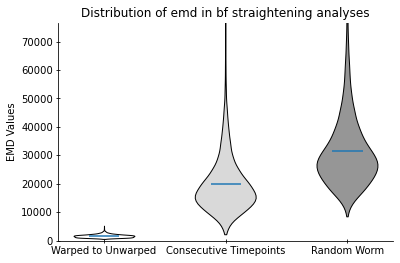

pixel intensity


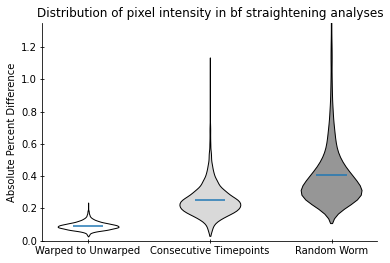

area


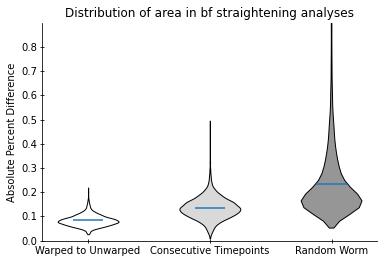

gfp


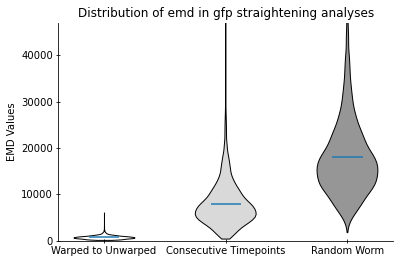

pixel intensity


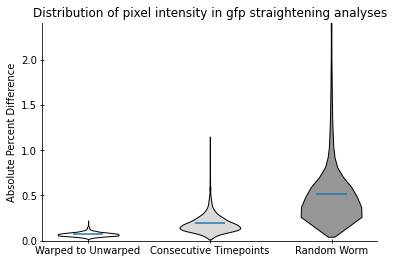

area


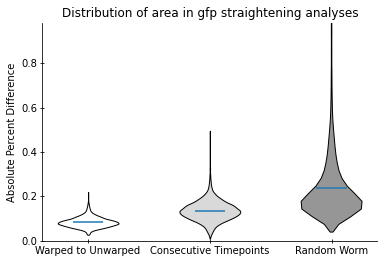

log
bf


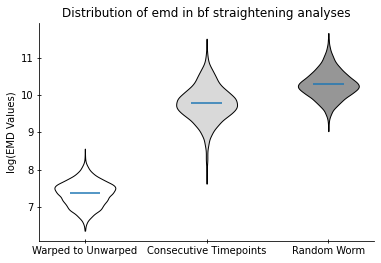

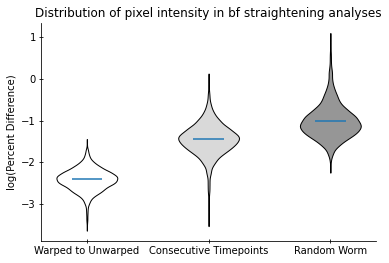

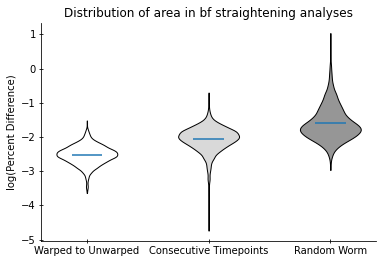

log
gfp


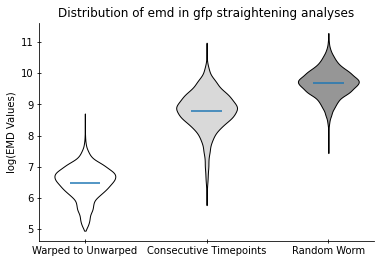

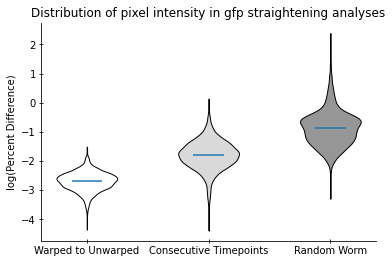

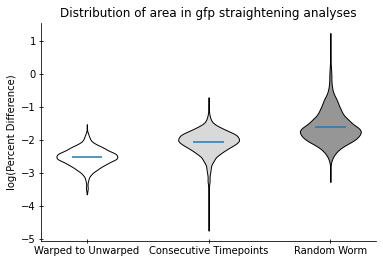

In [37]:
importlib.reload(straightening_analysis_utils)
save_dir = '/mnt/lugia_array/Laird_Nicolette/figures/straightening_analysis/norm_vals/'
for c, measurement_list in measure_dict.items():
    #c = c+"_seaborn"
    print(c)
    save_things(measurement_list, c, save_dir)

save_dir = '/mnt/lugia_array/Laird_Nicolette/figures/straightening_analysis/log_vals/'
for c, measurement_list in measure_dict.items():
    #c = c+"_seaborn"
    print('log')
    print(c)
    save_things(measurement_list, c, save_dir, log=True)

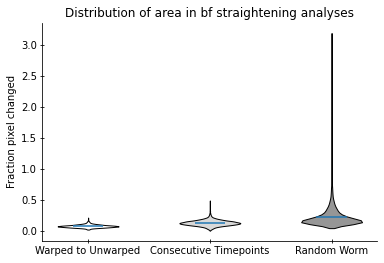

In [23]:
d = measurement_list['area']
plot_violin(d, "Distribution of area in bf straightening analyses", save_dir, "area")

In [20]:
import pandas as pd
data = pd.DataFrame.from_dict({k:measurement_list[k] for k in ('warp to unwarped', 'consecutive timepoint measurements', 'worm vs random worm')})

In [59]:
means = [data[k].mean() for k in ('warp to unwarped', 'consecutive timepoint measurements', 'worm vs random worm')]
means

[0.07087128008640758, 0.11869258647084219, 0.225632477642731]

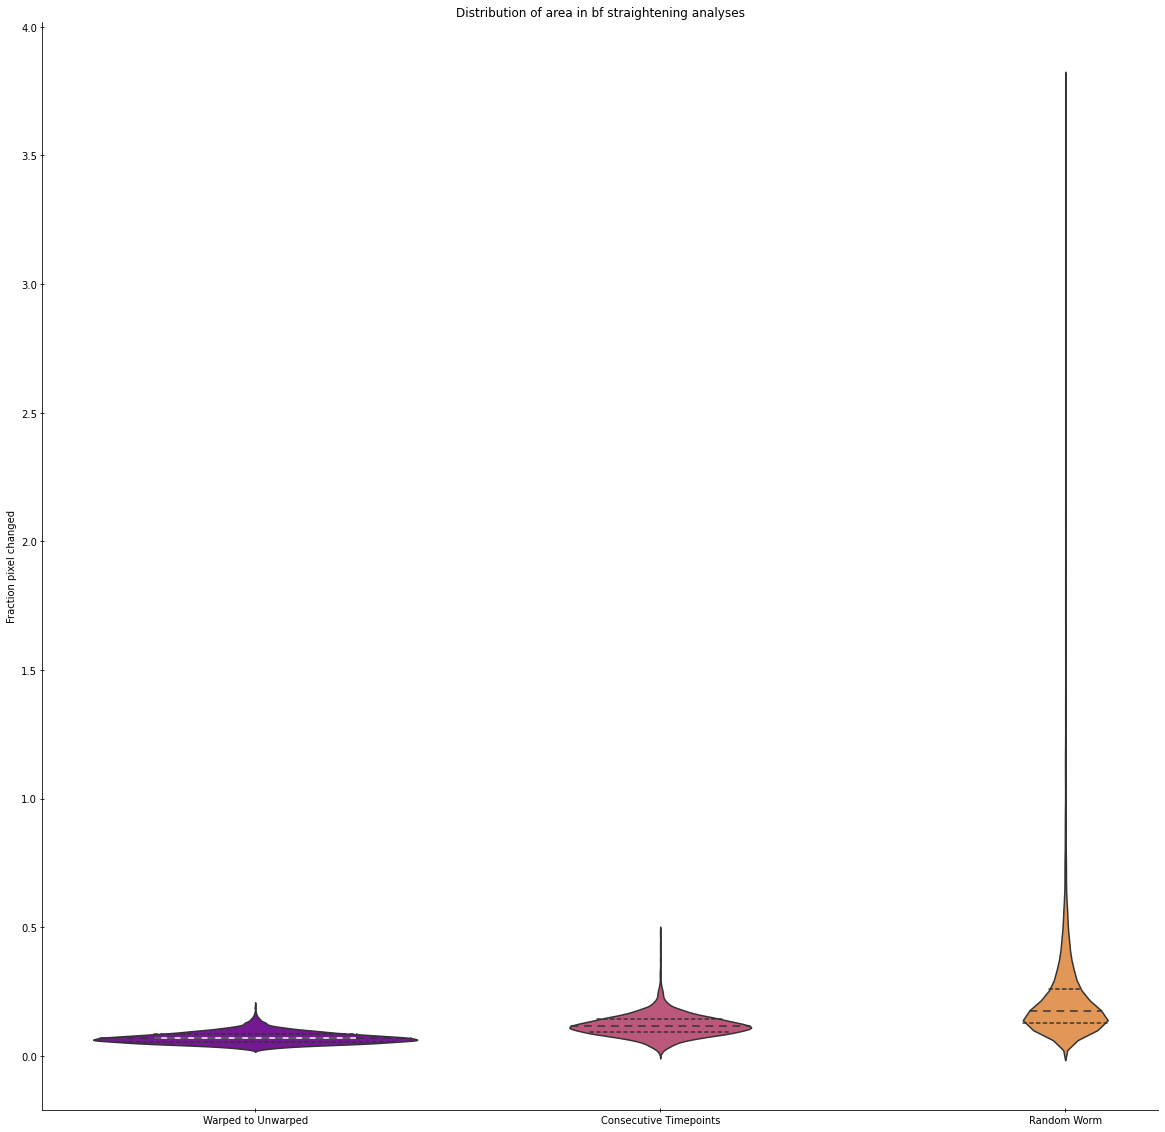

In [75]:
fig, ax = plt.subplots(figsize=(20,20))
sns.violinplot(data=data, ax=ax, palette='plasma', inner='quartile')

ax.set_xticklabels(['Warped to Unwarped', 'Consecutive Timepoints', 'Random Worm'])
ax.set_title("Distribution of area in bf straightening analyses")

ax.set_ylabel('Fraction pixel changed')
ax.hlines(means[0], -0.25,0.25, color='white')

Text(0, 0.5, 'Fraction pixel changed')

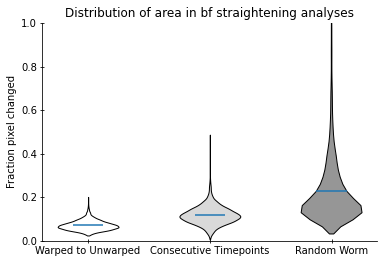

In [121]:
d = measurement_list['area']
cmap = plt.get_cmap('Greys', 5)

#colors = [cmap(i) for i in range(0,3)]
fig, ax = plt.subplots()
positions = numpy.array([1,2,3])

parts = ax.violinplot([d['warp to unwarped'], d['consecutive timepoint measurements'], 
        d['worm vs random worm']], positions, showmeans=True, showextrema=False)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Warped to Unwarped', 'Consecutive Timepoints', 'Random Worm'])
ax.set_title("Distribution of area in bf straightening analyses")

for i, pc in enumerate(parts['bodies']):
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_facecolors(cmap(i))
    

ax.set_ylim(0,1.0)

ax.set_ylabel('Fraction pixel changed')

In [40]:
ymax = numpy.percentile(d['worm vs random worm'], 99)
above = sum(i>ymax for i in d['worm vs random worm'])
above/len(d['worm vs random worm'])

0.010043942247332079

In [25]:
measurement_list.keys()

dict_keys(['emd', 'pixel intensity', 'area'])